# Topic Coherence Evaluation

In [1]:
from csv import reader
import pandas as pd
import re
import numpy as np
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt

def visualize_coherence(save_path, coherence_scores, title, labels, colors, start, limit, step):
        """
        Function to display num_topics - topic coherence coherence

        Parameters:
        ----------
        save_path : path to save image
        coherence_score : list of coherence scores
        title : graph title
        metric_label : topic coherence metric label
        color : color of plot
        start : starting index of topics
        limit : end index of topics
        step : step for topics
        Returns:
        -------
        """

        print('INFO: creating evalution visualization')  
        # Show graph
        

        
        x = range(start, limit, step)
        
        if len(coherence_scores) == 1:
            m, b = np.polyfit(x, coherence_scores[0], 1)

            # line of best fit
            plt.plot(x, m*x + b, color='orange')
        
        # plot data
        figs = []
        for i in range(len(coherence_scores)):
            
            figs.append(plt.plot(x, coherence_scores[i], label=labels[i], linestyle='none', marker='o', color=colors[i]))
        
        
        tit = plt.suptitle(title)
        plt.xlabel("Number of Topics")
        plt.ylabel("Coherence Score")
        lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, borderpad=1)
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        plt.savefig(save_path, bbox_extra_artists=(lgd,tit,), bbox_inches='tight')
        
        plt.figure(num=None, figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k')

        plt.show()



# function to tokenize the unstructured text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations    

'''
fn to get topic coherence from a list of topics

topics: list of topics
texts: the raw text corpus
id2word: the gensim corpora dictionary
coherence: the gensim coherence metric
'''
def get_coherence_score(topics, texts, id2word, coherence='umass'):
    
    corpus = [id2word.doc2bow(tok) for tok in texts]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=id2word, coherence=coherence)
    
    coherence_model_score = coherence_model.get_coherence()
    return coherence_model_score


def generate_coherence_score(data_file_path, topic_path_prefix, num_topics_list):
    '''
    generate_coherence_score

    this fn will generate a tuple of the umass and uci coherence scores over a number of topics
    for a topic model

    @data_file_path: the path to the raw data that will be used to score the coherence of a model

    @topic_path_prefix: this paramater is a string that represents the prefix that will be used to open the topics for each model: 
        needs to fit the pattern ^'../results/lsi/descriptions/lsi-description-'$, the suffix
        is the same for all of the model results and will be appended with a hardcoded string 
        <num_topic>topics.txt

    @num_topics_list: this parameter is a list of integers for the number of topics that were generated for a models results

    '''
    with open(data_file_path) as d:
        data_lines = []
        
        # break the data file up into tokens
        for line in d.readlines():
            line = re.sub('\n', '', line)
            data_lines.append(line)
        


        umass_coherence = []
        uci_coherence = []

        for k in num_topics_list:

            with open(topic_path_prefix + str(k) + 'topics.txt') as f:
                
                topics = []
                for line in f.readlines():
                    words = []
                    for word in line.split():
                        word = re.sub(',', '', word)
                        words.append(word)
                    topics.append(words)

                data_tokens = list(sent_to_words(data_lines))

                # generate id2word dictionary of bigrams
                id2word = corpora.Dictionary(data_tokens)


                # generate corpus from bigrams
                corpus = [id2word.doc2bow(tok) for tok in data_tokens]
                umass = get_coherence_score(topics, data_tokens, id2word, 'u_mass')
                uci = get_coherence_score(topics, data_tokens, id2word, 'c_uci')

                umass_coherence.append(umass)
                uci_coherence.append(uci)
        print('INFO finished generating coherence ' +
              ' scores for raw data: {} and model results: {}'.format(data_file_path, topic_path_prefix))
        return (umass_coherence, uci_coherence)

pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

pd.set_option('max_colwidth', 200)

# Generate Topic Coherence Table

In [2]:
# view topic coherence score

def generate_tc_df(umass, uci, model_names):
    
    dfs = []
    for i in range(len(umass)):
        df = pd.DataFrame(list(zip(umass[i], uci[i])), index=[i for i in range(10,105,5)], columns=['UMass', 'UCI'])
        dfs.append(df)
    
    print(len(dfs))
#     tc_comp = pd.concat(dfs, axis=1, keys=model_names)
    tc_comp = pd.concat(dfs, axis=1, keys=model_names)
    
    
    
    
#     print(tc_comp, end='\n\n\n\n')
#     print(dfs)
    return tc_comp

# Generate Topics Table

In [3]:
import re
def generate_topics_df(file_name, model_name, k):
    with open(file_name) as f:
        topics = [line for line in f.readlines()]
        df = pd.DataFrame(topics, index=[i + 1 for i in range(k)], columns=['Topics'])
        df = df['Topics'].map(lambda x: re.sub('\n', '', x))
#     topic_display = pd.concat([df], axis=1, keys=[model_name])
    
    return df

# Variance

In [4]:
import statistics

def calc_variance(tc):
    return round(statistics.variance(tc), 3)

# Model Evaluation

This section will analyze the performance of the different topic models

### LSI Topic Coherence Generation

In [5]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for lsi')
lsi_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/lsi/descriptions/lsi-description-',
                        desc_title_num_topics
                      )

print(lsi_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for lsi')
lsi_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/lsi/titles/lsi-title-',
                        desc_title_num_topics
                    )
print(lsi_title_tc)

print('INFO: generating preview coherence scores for lsi')
lsi_preview_tc =     generate_coherence_score(
                        'datasets/parsed_small_half_previews.txt',
                        '../results/lsi/previews/lsi-preview-',
                        desc_title_num_topics
                    )
print(lsi_preview_tc)

INFO: generating description coherence scores for lsi
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/lsi/descriptions/lsi-description-
([-5.859218389198672, -4.984199885524811, -6.463798966187267, -5.370840153383402, -5.50472850739282, -6.197304829912619, -7.093451609706482, -7.416171175002037, -8.00826951199404, -8.43862590251067, -8.833071545405746, -8.870775741487849, -9.790131650344838, -9.749046920089425, -10.413961778872778, -10.697492507042126, -10.873294342901117, -11.292425756134497, -11.394802195954421], [-3.0870547217721507, -2.5455266509139913, -3.72998111443993, -2.8002704424961853, -3.0681807862679507, -3.892032373033842, -4.734611643405903, -5.036511610875596, -5.461923310020906, -5.7530884529040875, -6.17918330722027, -6.191108232961799, -6.880143141814902, -6.872615323737267, -7.567446176648042, -7.795144712439777, -7.913459532377886, -8.359394760971599, -8.325340406699086])


INFO: generatin

# LSI TC Tables

In [369]:
# lsi description table

# lsi_d_tc_df = generate_tc_df([lsi_description_tc[0]], [lsi_description_tc[1]], ['LSI'])

# lsi_d_tc_df = lsi_d_tc_df.round(3)
# print(lsi_d_tc_df)

# print(lsi_d_tc_df.to_latex(index=True))

# lsi_15_k = generate_topics_df('../results/lsi/descriptions/lsi-description-15topics.txt', 'LSI', 15)

# print(lsi_15_k)
# print(lsi_15_k.to_latex(index=True) end='\n\n\n\n\n\n\n\n\n')


# lsi title table

# lsi_t_tc_df = generate_tc_df([lsi_title_tc[0]], [lsi_title_tc[1]], ['LSI'])

# lsi_t_tc_df = lsi_t_tc_df.round(3)
# print(lsi_t_tc_df)

# print(lsi_t_tc_df.to_latex(index=True))

# lsi_k = generate_topics_df('../results/lsi/titles/lsi-title-10topics.txt', 'LSI', 10)

# print(lsi_k)
# print(lsi_k.to_latex(index=True))

lsi_p_tc_df = generate_tc_df([lsi_preview_tc[0]], [lsi_preview_tc[1]], ['LSI'])

print('UMass title variance', calc_variance(lsi_title_tc[0]))
print('UCI title variance', calc_variance(lsi_title_tc[1]))

print('UMass description variance', calc_variance(lsi_description_tc[0]))
print('UCI description variance', calc_variance(lsi_description_tc[1]))

print('UMass preview variance', calc_variance(lsi_preview_tc[0]))
print('UCI preview variance', calc_variance(lsi_preview_tc[1]))

lsi_p_tc_df = lsi_p_tc_df.round(3)
print(lsi_p_tc_df)

print(lsi_p_tc_df.to_latex(index=True))

lsi_k = generate_topics_df('../results/lsi/previews/lsi-preview-25topics.txt', 'LSI', 25)

print(lsi_k)
print(lsi_k.to_latex(index=True))

1
UMass title variance 3.734
UCI title variance 2.854
UMass description variance 4.654
UCI description variance 3.913
UMass preview variance 0.588
UCI preview variance 0.514
       LSI       
     UMass    UCI
10  -4.915 -5.294
15  -5.281 -6.560
20  -5.217 -6.153
25  -4.959 -5.652
30  -5.604 -5.834
35  -5.375 -5.271
40  -5.096 -5.069
45  -5.159 -5.250
50  -5.522 -5.594
55  -5.979 -5.909
60  -6.064 -6.290
65  -6.295 -6.281
70  -6.527 -6.736
75  -6.675 -6.876
80  -6.353 -6.661
85  -6.700 -6.918
90  -7.018 -7.084
95  -7.038 -7.049
100 -7.183 -7.375
\begin{tabular}{lrr}
\toprule
{} & \multicolumn{2}{l}{LSI} \\
{} &  UMass &    UCI \\
\midrule
10  & -4.915 & -5.294 \\
15  & -5.281 & -6.560 \\
20  & -5.217 & -6.153 \\
25  & -4.959 & -5.652 \\
30  & -5.604 & -5.834 \\
35  & -5.375 & -5.271 \\
40  & -5.096 & -5.069 \\
45  & -5.159 & -5.250 \\
50  & -5.522 & -5.594 \\
55  & -5.979 & -5.909 \\
60  & -6.064 & -6.290 \\
65  & -6.295 & -6.281 \\
70  & -6.527 & -6.736 \\
75  & -6.675 & -6.876 \\
80 

### LDA Topic Coherence

In [133]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for lda')
lda_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/lda/descriptions/lda-description-',
                        desc_title_num_topics
                      )

print(lda_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for lda')
lda_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/lda/titles/lda-title-',
                        desc_title_num_topics
                    )
print(lda_title_tc)

print('INFO: generating preview coherence scores for lda')
lda_preview_tc =     generate_coherence_score(
                        'datasets/parsed_small_half_previews.txt',
                        '../results/lda/previews/lda-preview-',
                        desc_title_num_topics
                    )
print(lda_preview_tc)

INFO: generating description coherence scores for lda
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/lda/descriptions/lda-description-
([-5.028548924823591, -4.981829120431677, -5.499736333744547, -6.043571461032274, -5.72841690077783, -6.3935827767815185, -6.402413922864028, -6.353051496513843, -7.370888455877525, -7.1164725422313255, -7.10799903662323, -7.066907110560028, -7.887359477381855, -7.674803017290013, -7.9190551637725175, -8.869428325878351, -8.374210764233796, -8.35394497567882, -9.127348345009691], [-2.108276445931396, -2.166281233489007, -2.684780237083479, -3.063227683605237, -2.859622226997287, -3.3251450756960064, -3.4620101649926567, -3.189251785816026, -4.0982079438716825, -3.905300859857621, -3.846467103342639, -3.781289338544121, -4.546839809128515, -4.204886795719195, -4.410185436342408, -5.256607535773454, -4.76852255326634, -4.7552571864611854, -5.264392520725603])


INFO: generating 

# LDA TC Tables

In [370]:
# # lsi description table

# lda_df = generate_tc_df([lda_description_tc[0]], [lda_description_tc[1]], ['LDA'])

# lda_df = lda_df.round(3)
# print(lda_df)

# print(lda_df.to_latex(index=True))

# lda_k = generate_topics_df('../results/lda/descriptions/lda-description-15topics.txt', 'LDA', 15)

# print(lda_k)
# print(lda_k.to_latex(index=True))

# lda title table

# lda_df = generate_tc_df([lda_title_tc[0]], [lda_title_tc[1]], ['LDA'])

# lda_df = lda_df.round(3)
# print(lda_df)

# print(lda_df.to_latex(index=True))

# lda_k = generate_topics_df('../results/lda/titles/lda-title-20topics.txt', 'LDA', 20)

# print(lda_k)
# print(lda_k.to_latex(index=True))
print('UMass title variance', calc_variance(lda_title_tc[0]))
print('UCI title variance', calc_variance(lda_title_tc[1]))

print('UMass description variance', calc_variance(lda_description_tc[0]))
print('UCI description variance', calc_variance(lda_description_tc[1]))

print('UMass preview variance', calc_variance(lda_preview_tc[0]))
print('UCI preview variance', calc_variance(lda_preview_tc[1]))

lda_df = generate_tc_df([lda_preview_tc[0]], [lda_preview_tc[1]], ['LDA'])

lda_df = lda_df.round(3)
print(lda_df)

print(lda_df.to_latex(index=True))

lda_k = generate_topics_df('../results/lda/previews/lda-preview-15topics.txt', 'LDA', 15)

print(lda_k)
print(lda_k.to_latex(index=True))

UMass title variance 1.065
UCI title variance 0.278
UMass description variance 1.549
UCI description variance 0.901
UMass preview variance 0.167
UCI preview variance 0.128
1
       LDA       
     UMass    UCI
10  -1.904 -1.757
15  -1.858 -2.123
20  -2.547 -2.142
25  -2.625 -2.757
30  -2.997 -2.751
35  -3.200 -3.149
40  -2.439 -2.594
45  -2.460 -2.254
50  -2.774 -2.194
55  -2.682 -2.447
60  -3.013 -2.497
65  -3.386 -2.461
70  -2.812 -2.066
75  -3.003 -1.707
80  -3.039 -2.335
85  -2.800 -1.859
90  -3.130 -2.161
95  -3.102 -2.224
100 -3.094 -2.189
\begin{tabular}{lrr}
\toprule
{} & \multicolumn{2}{l}{LDA} \\
{} &  UMass &    UCI \\
\midrule
10  & -1.904 & -1.757 \\
15  & -1.858 & -2.123 \\
20  & -2.547 & -2.142 \\
25  & -2.625 & -2.757 \\
30  & -2.997 & -2.751 \\
35  & -3.200 & -3.149 \\
40  & -2.439 & -2.594 \\
45  & -2.460 & -2.254 \\
50  & -2.774 & -2.194 \\
55  & -2.682 & -2.447 \\
60  & -3.013 & -2.497 \\
65  & -3.386 & -2.461 \\
70  & -2.812 & -2.066 \\
75  & -3.003 & -1.707 \\
80 

# lda2vec Topic Coherence

In [393]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for lda2vec')
lda2vec_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/lda2vec/descriptions/description-lda2vec-',
                        desc_title_num_topics
                      )

print(lda2vec_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for lda2vec')
lda2vec_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/lda2vec/titles/title-lda2vec-',
                        desc_title_num_topics
                    )

print(lda2vec_title_tc)

### Need to rerun lda2vec on previews ASAP!!!
print('INFO: generating preview coherence scores for lda2vec')
lda2vec_preview_tc =     generate_coherence_score(
                        'datasets/parsed_small_half_previews.txt',
                        '../results/lda2vec/previews/preview-lda2vec-',
                        desc_title_num_topics
                    )
print(lda2vec_preview_tc)

INFO: generating description coherence scores for lda2vec
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/lda2vec/descriptions/description-lda2vec-
([-8.102157281850895, -8.544679733054261, -10.734567642812422, -10.371018470578107, -9.153149447821516, -8.889478791822672, -8.64063186892989, -10.986376744371361, -9.805604209818254, -9.596741577445588, -9.469481730488619, -9.579918925632741, -9.548308980219312, -9.673937078451223, -9.20373430912613, -9.621014140857968, -9.705283313822122, -9.56226398140681, -9.561642089862072], [-5.0234026358806965, -5.307238206314144, -7.396281766285073, -7.084002710125337, -6.114673973873126, -6.156327401775496, -5.582346788762348, -7.708462734739735, -6.5771740118055275, -6.651926546385952, -6.378556949613307, -6.327542287091296, -6.3193631510271, -6.428594069967918, -5.955162741244331, -6.506502864735832, -6.406202334553752, -6.424623034802167, -6.2597959592974295])


INFO: g

# lda2vec Description Tables

In [401]:
# # lsi description table

# lda2vec_df = generate_tc_df([lda2vec_description_tc[0]], [lda2vec_description_tc[1]], ['lda2vec'])

# lda2vec_df = lda2vec_df.round(3)
# print(lda2vec_df)

# print(lda2vec_df.to_latex(index=True))

# lda2vec_k = generate_topics_df('../results/lda2vec/descriptions/description-lda2vec-10topics.txt', 'lda2vec', 10)

# print(lda2vec_k)
# print(lda2vec_k.to_latex(index=True))

# lsi description table
print('UMass title variance', calc_variance(lda2vec_title_tc[0]))
print('UCI title variance', calc_variance(lda2vec_title_tc[1]))

print('UMass description variance', calc_variance(lda2vec_description_tc[0]))
print('UCI description variance', calc_variance(lda2vec_description_tc[1]))

print('UMass preview variance', calc_variance(lda_preview_tc[0]))
print('UCI preview variance', calc_variance(lda_preview_tc[1]))
# lda2vec_df = generate_tc_df([lda2vec_title_tc[0]], [lda2vec_title_tc[1]], ['lda2vec'])

# lda2vec_df = lda2vec_df.round(3)
# print(lda2vec_df)

# print(lda2vec_df.to_latex(index=True))

# lda2vec_k = generate_topics_df('../results/lda2vec/titles/title-lda2vec-20topics.txt', 'lda2vec', 20)

# print(lda2vec_k)
# print(lda2vec_k.to_latex(index=True))

lda2vec_df = generate_tc_df([lda2vec_preview_tc[0]], [lda2vec_preview_tc[1]], ['lda2vec'])

lda2vec_df = lda2vec_df.round(3)
print(lda2vec_df)

print(lda2vec_df.to_latex(index=True))

lda2vec_k = generate_topics_df('../results/lda2vec/previews/preview-lda2vec-20topics.txt', 'lda2vec', 20)

print(lda2vec_k)
print(lda2vec_k.to_latex(index=True))

UMass title variance 0.903
UCI title variance 0.936
UMass description variance 0.493
UCI description variance 0.409
UMass preview variance 0.167
UCI preview variance 0.128
1
    lda2vec        
      UMass     UCI
10  -16.717 -13.474
15  -15.109 -13.119
20  -15.036 -12.749
25  -13.695 -12.317
30  -14.548 -12.174
35  -15.275 -12.683
40  -14.925 -12.061
45  -15.067 -12.288
50  -14.713 -12.002
55  -14.663 -12.104
60  -13.743 -11.530
65  -14.251 -11.848
70  -14.280 -11.514
75  -13.646 -11.191
80  -13.932 -11.564
85  -13.891 -11.327
90  -14.263 -11.901
95  -13.801 -11.483
100 -14.893 -11.770
\begin{tabular}{lrr}
\toprule
{} & \multicolumn{2}{l}{lda2vec} \\
{} &   UMass &     UCI \\
\midrule
10  & -16.717 & -13.474 \\
15  & -15.109 & -13.119 \\
20  & -15.036 & -12.749 \\
25  & -13.695 & -12.317 \\
30  & -14.548 & -12.174 \\
35  & -15.275 & -12.683 \\
40  & -14.925 & -12.061 \\
45  & -15.067 & -12.288 \\
50  & -14.713 & -12.002 \\
55  & -14.663 & -12.104 \\
60  & -13.743 & -11.530 \\
65  & -1

# ETM Topic Coherence

In [134]:
desc_title_num_topics = [ 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100 ]

print('INFO: generating description coherence scores for etm')
etm_description_tc =  generate_coherence_score(
                        'datasets/parsed_full_descriptions.txt',
                        '../results/etm/descriptions/description-etm-',
                        desc_title_num_topics
                      )

print(etm_description_tc, end='\n\n\n')

print('INFO: generating title coherence scores for etm')
etm_title_tc =     generate_coherence_score(
                        'datasets/parsed_full_titles.txt',
                        '../results/etm/titles/title-etm-',
                        desc_title_num_topics
                    )
print(etm_title_tc)

print('INFO: generating preview coherence scores for etm')
etm_preview_tc =     generate_coherence_score(
                        'datasets/parsed_small_half_previews.txt',
                        '../results/etm/previews/preview-etm-',
                        desc_title_num_topics
                    )
print(etm_preview_tc)

INFO: generating description coherence scores for etm
INFO finished generating coherence  scores for raw data: datasets/parsed_full_descriptions.txt and model results: ../results/etm/descriptions/description-etm-
([-5.535945204532871, -5.1763433109676384, -4.523123539084188, -5.693011882911394, -5.538413099033175, -5.352027384793378, -5.590688378840148, -5.18265627730716, -5.182670266156553, -5.209332137100639, -4.52897376169601, -5.0191108466012055, -5.053149715244237, -5.267712625181472, -5.130493719424554, -5.35592894947335, -5.104480661780863, -5.386202432245379, -5.1188266927645785], [-2.5173661638047475, -2.330320461907496, -1.582907094491389, -2.7753202725037625, -2.653778920470622, -2.3329674293266707, -2.60304620830147, -2.271428370405957, -2.2589604951257884, -2.360780897586848, -1.724257524877004, -2.0930303000190604, -2.0568828967442347, -2.3083674892657333, -2.1995508884267947, -2.489945451778978, -2.224817140761242, -2.5299141164851577, -2.2817638354418515])


INFO: gener

# ETM Description Tables

In [372]:
# # etm description table

# etm_df = generate_tc_df([etm_description_tc[0]], [etm_description_tc[1]], ['ETM'])

# etm_df = etm_df.round(3)
# print(etm_df)

# print(etm_df.to_latex(index=True))

# etm_k = generate_topics_df('../results/etm/descriptions/description-etm-20topics.txt', 'ETM', 20)

# print(etm_k)
# print(etm_k.to_latex(index=True))

# etm description table

# etm_df = generate_tc_df([etm_title_tc[0]], [etm_title_tc[1]], ['ETM'])

# etm_df = etm_df.round(3)
# print(etm_df)

# print(etm_df.to_latex(index=True))

# etm_k = generate_topics_df('../results/etm/titles/title-etm-10topics.txt', 'ETM', 10)

# print(etm_k)
# print(etm_k.to_latex(index=True))
print('UMass title variance', calc_variance(etm_title_tc[0]))
print('UCI title variance', calc_variance(etm_title_tc[1]))

print('UMass description variance', calc_variance(etm_description_tc[0]))
print('UCI description variance', calc_variance(etm_description_tc[1]))

print('UMass preview variance', calc_variance(etm_preview_tc[0]))
print('UCI preview variance', calc_variance(etm_preview_tc[1]))

etm_df = generate_tc_df([etm_preview_tc[0]], [etm_preview_tc[1]], ['ETM'])

etm_df = etm_df.round(3)
print(etm_df)

print(etm_df.to_latex(index=True))

etm_k = generate_topics_df('../results/etm/previews/preview-etm-20topics.txt', 'ETM', 20)

print(etm_k)
print(etm_k.to_latex(index=True))

UMass title variance 0.311
UCI title variance 0.236
UMass description variance 0.094
UCI description variance 0.086
UMass preview variance 0.021
UCI preview variance 0.32
1
       ETM       
     UMass    UCI
10  -1.025 -0.683
15  -1.170 -1.047
20  -1.290 -0.839
25  -1.284 -1.009
30  -1.374 -1.617
35  -1.385 -1.648
40  -1.418 -1.702
45  -1.447 -1.812
50  -1.448 -1.961
55  -1.474 -2.083
60  -1.470 -1.938
65  -1.471 -1.948
70  -1.518 -2.013
75  -1.587 -2.375
80  -1.559 -2.333
85  -1.582 -2.487
90  -1.539 -2.288
95  -1.538 -2.352
100 -1.510 -2.523
\begin{tabular}{lrr}
\toprule
{} & \multicolumn{2}{l}{ETM} \\
{} &  UMass &    UCI \\
\midrule
10  & -1.025 & -0.683 \\
15  & -1.170 & -1.047 \\
20  & -1.290 & -0.839 \\
25  & -1.284 & -1.009 \\
30  & -1.374 & -1.617 \\
35  & -1.385 & -1.648 \\
40  & -1.418 & -1.702 \\
45  & -1.447 & -1.812 \\
50  & -1.448 & -1.961 \\
55  & -1.474 & -2.083 \\
60  & -1.470 & -1.938 \\
65  & -1.471 & -1.948 \\
70  & -1.518 & -2.013 \\
75  & -1.587 & -2.375 \\
80  

# Description Topic Coherence Performance

In [329]:
desc_df = generate_tc_df(
    [lsi_description_tc[0], lda_description_tc[0],lda2vec_description_tc[0], etm_description_tc[0]],
    [lsi_description_tc[1], lda_description_tc[1],lda2vec_description_tc[1], etm_description_tc[1]],
    ['LSI', 'LDA', 'lda2vec', 'ETM'])

desc_df = desc_df.round(3)
print(desc_df)
print(desc_df.to_latex(index=True))

# desc_df.head()

4
        LSI           LDA        lda2vec           ETM       
      UMass    UCI  UMass    UCI   UMass    UCI  UMass    UCI
10   -5.859 -3.087 -5.029 -2.108  -8.102 -5.023 -5.536 -2.517
15   -4.984 -2.546 -4.982 -2.166  -8.545 -5.307 -5.176 -2.330
20   -6.464 -3.730 -5.500 -2.685 -10.735 -7.396 -4.523 -1.583
25   -5.371 -2.800 -6.044 -3.063 -10.371 -7.084 -5.693 -2.775
30   -5.505 -3.068 -5.728 -2.860  -9.153 -6.115 -5.538 -2.654
35   -6.197 -3.892 -6.394 -3.325  -8.889 -6.156 -5.352 -2.333
40   -7.093 -4.735 -6.402 -3.462  -8.641 -5.582 -5.591 -2.603
45   -7.416 -5.037 -6.353 -3.189 -10.986 -7.708 -5.183 -2.271
50   -8.008 -5.462 -7.371 -4.098  -9.806 -6.577 -5.183 -2.259
55   -8.439 -5.753 -7.116 -3.905  -9.597 -6.652 -5.209 -2.361
60   -8.833 -6.179 -7.108 -3.846  -9.469 -6.379 -4.529 -1.724
65   -8.871 -6.191 -7.067 -3.781  -9.580 -6.328 -5.019 -2.093
70   -9.790 -6.880 -7.887 -4.547  -9.548 -6.319 -5.053 -2.057
75   -9.749 -6.873 -7.675 -4.205  -9.674 -6.429 -5.268 -2.308
80  -1

# Title TC Perf

In [341]:
desc_df = generate_tc_df(
    [lsi_title_tc[0], lda_title_tc[0],lda2vec_title_tc[0], etm_title_tc[0]],
    [lsi_title_tc[1], lda_title_tc[1],lda2vec_title_tc[1], etm_title_tc[1]],
    ['LSI', 'LDA', 'lda2vec', 'ETM'])

desc_df = desc_df.round(3)
print(desc_df)
print(desc_df.to_latex(index=True))

# desc_df.head()

4
        LSI             LDA        lda2vec           ETM       
      UMass     UCI   UMass    UCI   UMass    UCI  UMass    UCI
10   -9.687  -5.975 -10.364 -6.718  -8.467 -6.003 -8.265 -5.273
15  -10.903  -7.084 -10.228 -6.538 -10.435 -7.471 -9.573 -6.428
20  -12.441  -8.593 -10.709 -6.692  -7.414 -4.765 -9.846 -6.576
25  -13.247  -9.334 -10.740 -6.868  -8.998 -6.074 -9.464 -6.280
30  -12.343  -8.254 -10.708 -6.569  -7.937 -5.026 -9.132 -6.043
35  -13.305  -9.381 -11.444 -7.125 -10.015 -7.245 -9.474 -6.392
40  -13.581  -9.475 -11.344 -7.071  -7.339 -4.362 -7.934 -5.010
45  -13.980  -9.874 -11.450 -7.126  -8.253 -5.227 -8.366 -5.353
50  -14.417 -10.234 -11.988 -7.488  -8.824 -5.880 -8.853 -5.888
55  -14.632 -10.434 -11.665 -7.217  -8.331 -5.158 -8.901 -5.886
60  -15.160 -10.886 -11.961 -7.291  -9.308 -6.268 -9.555 -6.461
65  -15.409 -11.101 -12.617 -7.851  -8.696 -5.493 -8.659 -5.651
70  -15.473 -11.114 -13.407 -8.348 -10.347 -7.495 -9.415 -6.341
75  -15.886 -11.498 -13.113 -8.078  -8

# Preview TC Perf

In [402]:
pre_df = generate_tc_df(
    [lsi_preview_tc[0], lda_preview_tc[0],lda2vec_preview_tc[0], etm_preview_tc[0]],
    [lsi_preview_tc[1], lda_preview_tc[1],lda2vec_preview_tc[1], etm_preview_tc[1]],
    ['LSI', 'LDA', 'lda2vec', 'ETM'])

pre_df = pre_df.round(3)
print(pre_df)
print(pre_df.to_latex(index=True))

# desc_df.head()

4
       LSI           LDA        lda2vec            ETM       
     UMass    UCI  UMass    UCI   UMass     UCI  UMass    UCI
10  -4.915 -5.294 -1.904 -1.757 -16.717 -13.474 -1.025 -0.683
15  -5.281 -6.560 -1.858 -2.123 -15.109 -13.119 -1.170 -1.047
20  -5.217 -6.153 -2.547 -2.142 -15.036 -12.749 -1.290 -0.839
25  -4.959 -5.652 -2.625 -2.757 -13.695 -12.317 -1.284 -1.009
30  -5.604 -5.834 -2.997 -2.751 -14.548 -12.174 -1.374 -1.617
35  -5.375 -5.271 -3.200 -3.149 -15.275 -12.683 -1.385 -1.648
40  -5.096 -5.069 -2.439 -2.594 -14.925 -12.061 -1.418 -1.702
45  -5.159 -5.250 -2.460 -2.254 -15.067 -12.288 -1.447 -1.812
50  -5.522 -5.594 -2.774 -2.194 -14.713 -12.002 -1.448 -1.961
55  -5.979 -5.909 -2.682 -2.447 -14.663 -12.104 -1.474 -2.083
60  -6.064 -6.290 -3.013 -2.497 -13.743 -11.530 -1.470 -1.938
65  -6.295 -6.281 -3.386 -2.461 -14.251 -11.848 -1.471 -1.948
70  -6.527 -6.736 -2.812 -2.066 -14.280 -11.514 -1.518 -2.013
75  -6.675 -6.876 -3.003 -1.707 -13.646 -11.191 -1.587 -2.375
80  -6

# Visualize Description Topic Coherence

INFO: creating evalution visualization


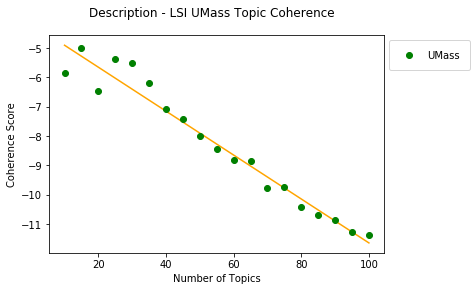

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


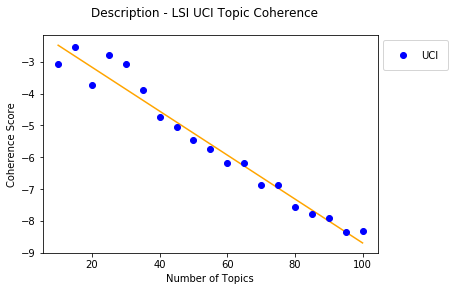

<Figure size 1000x600 with 0 Axes>

In [224]:
visualize_coherence(
    'results_figures/lsi/description/lsi-umass-description.png',
    [lsi_description_tc[0]],
    'Description - LSI UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lsi/description/lsi-uci-description.png',
    [lsi_description_tc[1]],
    'Description - LSI UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


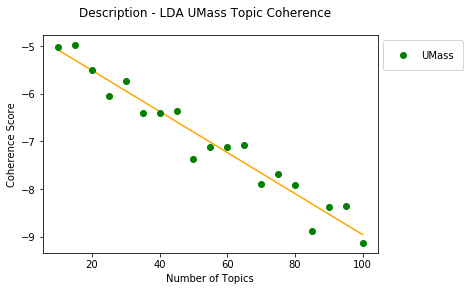

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


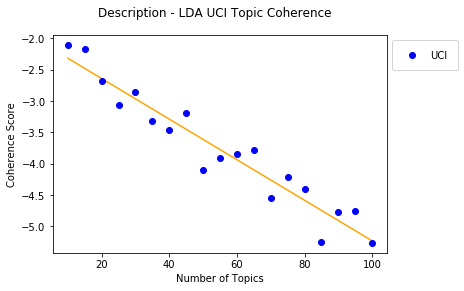

<Figure size 1000x600 with 0 Axes>

In [225]:
visualize_coherence(
    'results_figures/lda/description/lda-umass-description.png',
    [lda_description_tc[0]],
    'Description - LDA UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda/description/lda-uci-description.png',
    [lda_description_tc[1]],
    'Description - LDA UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


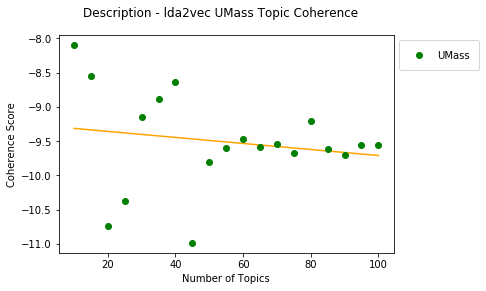

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


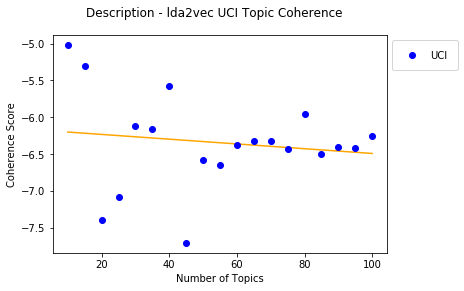

<Figure size 1000x600 with 0 Axes>

In [226]:
visualize_coherence(
    'results_figures/lda2vec/description/lda2vec-umass-description.png',
    [lda2vec_description_tc[0]],
    'Description - lda2vec UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda2vec/description/lda2vec-uci-description.png',
    [lda2vec_description_tc[1]],
    'Description - lda2vec UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)



INFO: creating evalution visualization


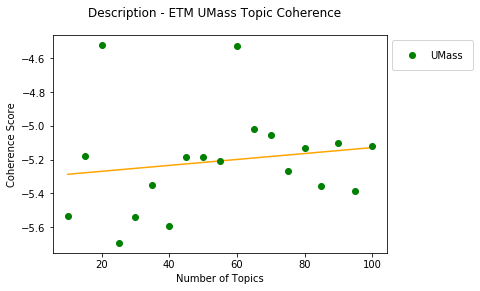

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


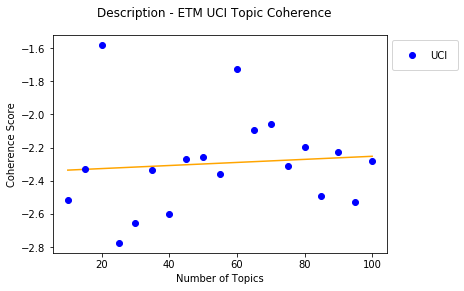

<Figure size 1000x600 with 0 Axes>

In [227]:
visualize_coherence(
    'results_figures/etm/description/etm-umass-description.png',
    [etm_description_tc[0]],
    'Description - ETM UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/etm/description/etm-uci-description.png',
    [etm_description_tc[1]],
    'Description - ETM UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)



### Description Comparison

INFO: creating evalution visualization


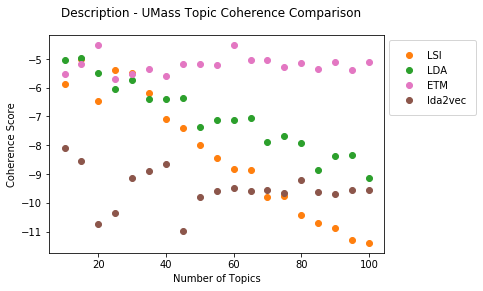

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


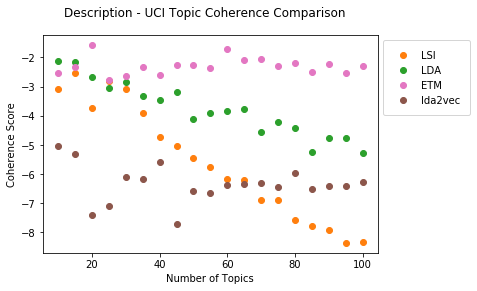

<Figure size 1000x600 with 0 Axes>

In [228]:
visualize_coherence(
    'results_figures/combined/umass-description.png',
    [lsi_description_tc[0], lda_description_tc[0], etm_description_tc[0], lda2vec_description_tc[0]],
    'Description - UMass Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM', 'lda2vec'],
    ['tab:orange', 'tab:green', 'tab:pink', 'tab:brown'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/combined/uci-description.png',
    [lsi_description_tc[1], lda_description_tc[1], etm_description_tc[1], lda2vec_description_tc[1]],
    'Description - UCI Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM', 'lda2vec'],
    ['tab:orange', 'tab:green', 'tab:pink', 'tab:brown'],
    10,
    105,
    5
)

# Title

INFO: creating evalution visualization


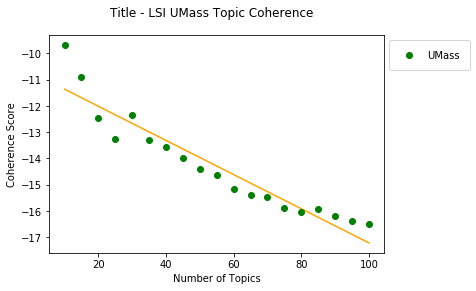

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


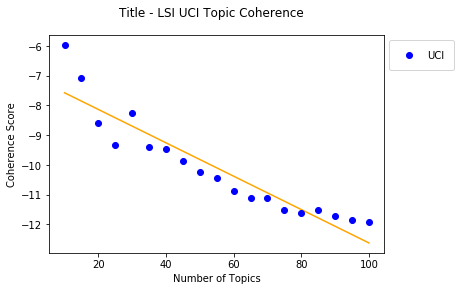

<Figure size 1000x600 with 0 Axes>

In [229]:
visualize_coherence(
    'results_figures/lsi/title/lsi-umass-title.png',
    [lsi_title_tc[0]],
    'Title - LSI UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lsi/title/lsi-uci-title.png',
    [lsi_title_tc[1]],
    'Title - LSI UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)



INFO: creating evalution visualization


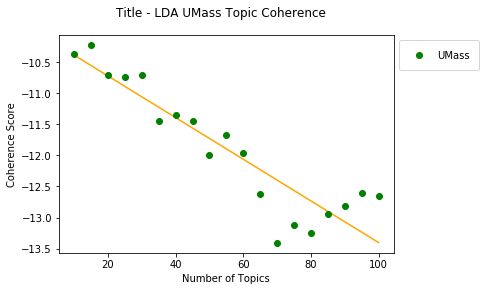

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


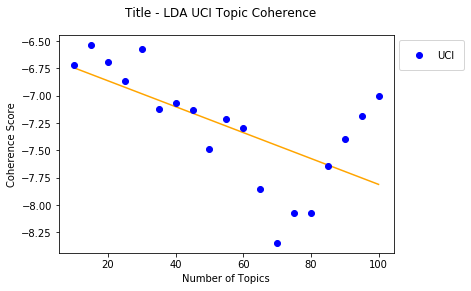

<Figure size 1000x600 with 0 Axes>

In [230]:
visualize_coherence(
    'results_figures/lda/title/lda-umass-title.png',
    [lda_title_tc[0]],
    'Title - LDA UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda/title/lda-uci-title.png',
    [lda_title_tc[1]],
    'Title - LDA UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


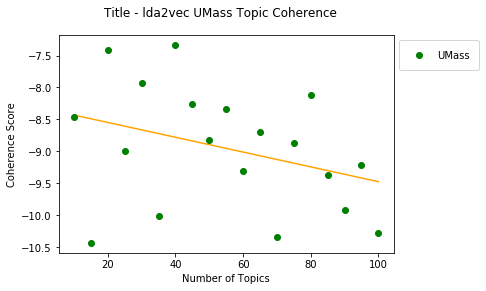

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


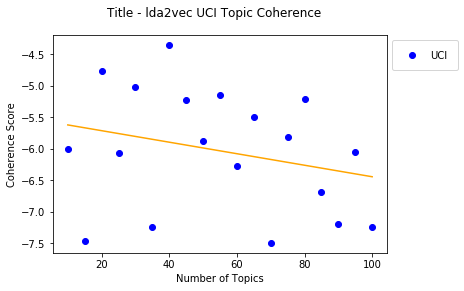

<Figure size 1000x600 with 0 Axes>

In [231]:
visualize_coherence(
    'results_figures/lda2vec/title/lda2vec-umass-title.png',
    [lda2vec_title_tc[0]],
    'Title - lda2vec UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda2vec/title/lda2vec-uci-title.png',
    [lda2vec_title_tc[1]],
    'Title - lda2vec UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)



INFO: creating evalution visualization


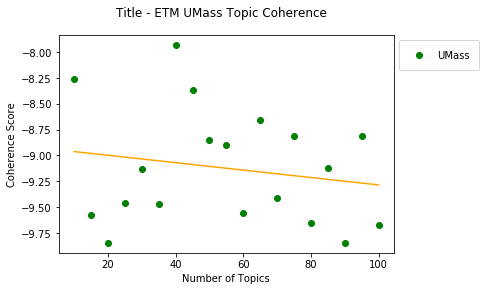

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


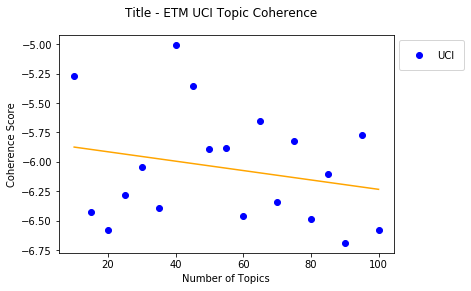

<Figure size 1000x600 with 0 Axes>

In [232]:
visualize_coherence(
    'results_figures/etm/title/etm-umass-title.png',
    [etm_title_tc[0]],
    'Title - ETM UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/etm/title/etm-uci-title.png',
    [etm_title_tc[1]],
    'Title - ETM UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)


### Title Comparison

INFO: creating evalution visualization


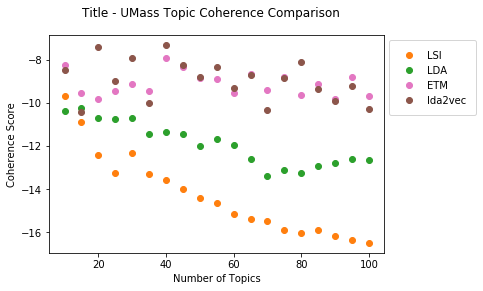

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


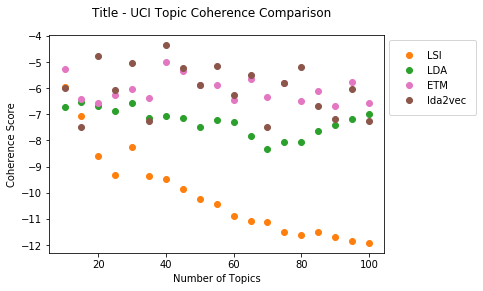

<Figure size 1000x600 with 0 Axes>

19


In [357]:
visualize_coherence(
    'results_figures/combined/umass-title.png',
    [lsi_title_tc[0], lda_title_tc[0], etm_title_tc[0], lda2vec_title_tc[0]],
    'Title - UMass Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM', 'lda2vec'],
    ['tab:orange', 'tab:green', 'tab:pink', 'tab:brown'],
    10,
    105,
    5
)
visualize_coherence(
    'results_figures/combined/uci-title.png',
    [lsi_title_tc[1], lda_title_tc[1], etm_title_tc[1], lda2vec_title_tc[1]],
    'Title - UCI Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM', 'lda2vec'],
    ['tab:orange', 'tab:green', 'tab:pink', 'tab:brown'],
    10,
    105,
    5
)
print(len(lsi_title_tc[0]))

# Preview Topic Coherence

INFO: creating evalution visualization


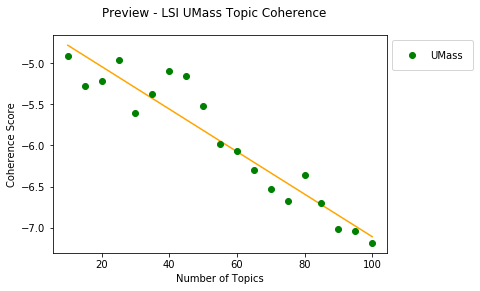

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


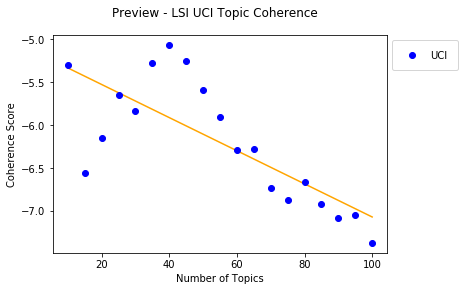

<Figure size 1000x600 with 0 Axes>

19
19


In [356]:
visualize_coherence(
    'results_figures/lsi/preview/lsi-umass-preview.png',
    [lsi_preview_tc[0]],
    'Preview - LSI UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lsi/preview/lsi-uci-preview.png',
    [lsi_preview_tc[1]],
    'Preview - LSI UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)

print(len(lsi_preview_tc[0]))
print(len(lsi_preview_tc[1]))

INFO: creating evalution visualization


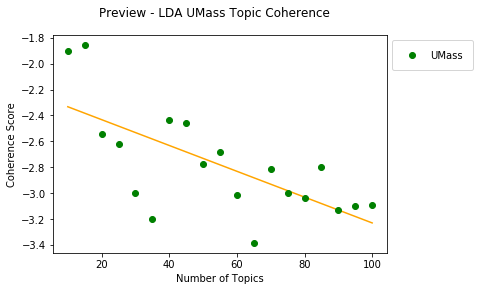

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


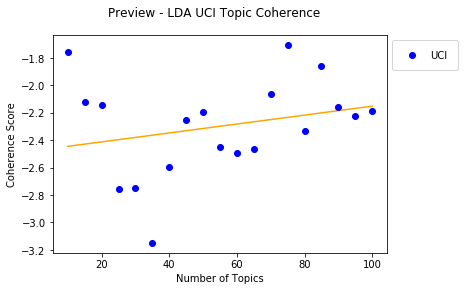

<Figure size 1000x600 with 0 Axes>

In [234]:
visualize_coherence(
    'results_figures/lda/preview/lda-umass-preview.png',
    [lda_preview_tc[0]],
    'Preview - LDA UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda/preview/lda-uci-preview.png',
    [lda_preview_tc[1]],
    'Preview - LDA UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


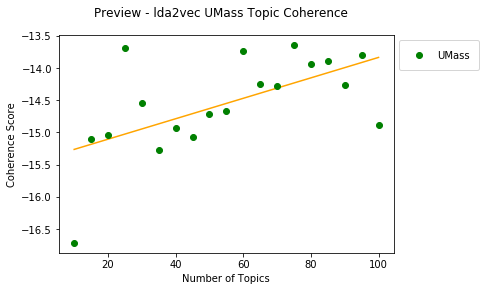

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


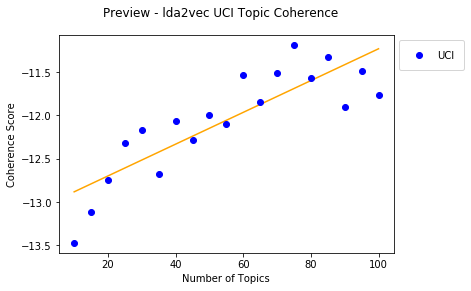

<Figure size 1000x600 with 0 Axes>

In [394]:
visualize_coherence(
    'results_figures/lda2vec/preview/lda2vec-umass-preview.png',
    [lda2vec_preview_tc[0]],
    'Preview - lda2vec UMass Topic Coherence',
    ['UMass'],
    'green',
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda2vec/preview/lda2vec-uci-preview.png',
    [lda2vec_preview_tc[1]],
    'Preview - lda2vec UCI Topic Coherence',
    ['UCI'],
    'blue',
    10,
    105,
    5
)



INFO: creating evalution visualization


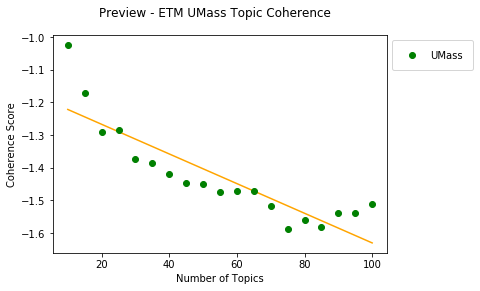

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


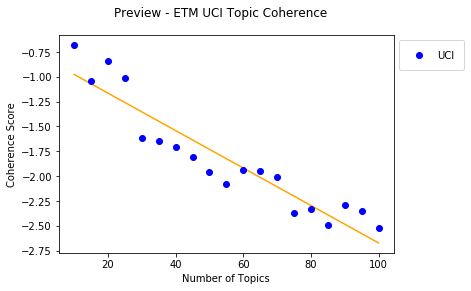

<Figure size 1000x600 with 0 Axes>

In [235]:
visualize_coherence(
    'results_figures/etm/preview/etm-umass-preview.png',
    [etm_preview_tc[0]],
    'Preview - ETM UMass Topic Coherence',
    ['UMass'],
    ['green'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/etm/preview/etm-uci-preview.png',
    [etm_preview_tc[1]],
    'Preview - ETM UCI Topic Coherence',
    ['UCI'],
    ['blue'],
    10,
    105,
    5
)


INFO: creating evalution visualization


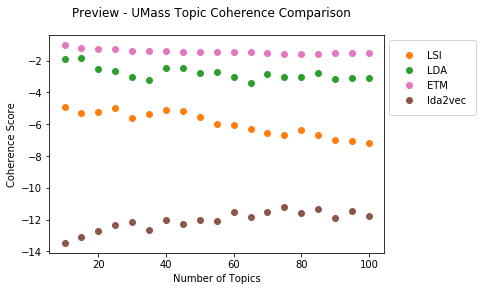

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


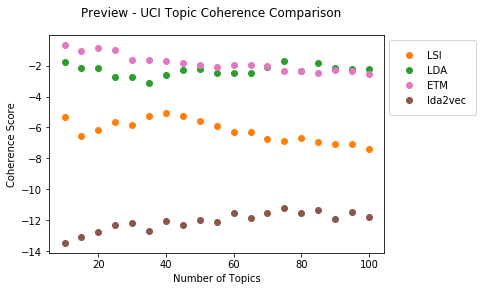

<Figure size 1000x600 with 0 Axes>

In [395]:
visualize_coherence(
    'results_figures/combined/umass-preview.png',
    [lsi_preview_tc[0], lda_preview_tc[0], etm_preview_tc[0], lda2vec_preview_tc[1]],
    'Preview - UMass Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM', 'lda2vec'],
    ['tab:orange', 'tab:green', 'tab:pink', 'tab:brown'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/combined/uci-preview.png',
    [lsi_preview_tc[1], lda_preview_tc[1], etm_preview_tc[1], lda2vec_preview_tc[1]],
    'Preview - UCI Topic Coherence Comparison',
    ['LSI', 'LDA', 'ETM', 'lda2vec'],
    ['tab:orange', 'tab:green', 'tab:pink', 'tab:brown'],
    10,
    105,
    5
)

# Dataset comparisons

### LSI

INFO: creating evalution visualization


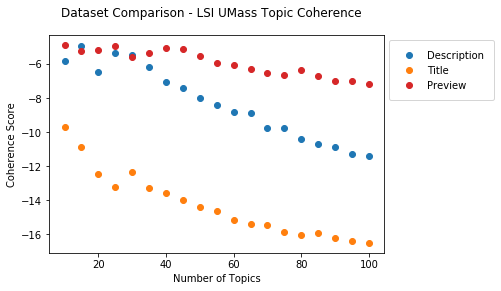

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


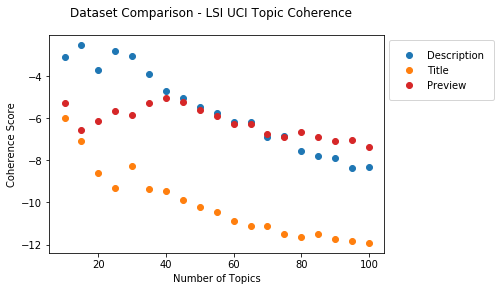

<Figure size 1000x600 with 0 Axes>

3
UMass title variance 3.734
UCI title variance 2.854
UMass description variance 4.654
UCI description variance 3.913
UMass preview variance 0.588
UCI preview variance 0.514
      Title         Description        Preview       
      UMass     UCI       UMass    UCI   UMass    UCI
10   -9.687  -5.975      -5.859 -3.087  -4.915 -5.294
15  -10.903  -7.084      -4.984 -2.546  -5.281 -6.560
20  -12.441  -8.593      -6.464 -3.730  -5.217 -6.153
25  -13.247  -9.334      -5.371 -2.800  -4.959 -5.652
30  -12.343  -8.254      -5.505 -3.068  -5.604 -5.834
35  -13.305  -9.381      -6.197 -3.892  -5.375 -5.271
40  -13.581  -9.475      -7.093 -4.735  -5.096 -5.069
45  -13.980  -9.874      -7.416 -5.037  -5.159 -5.250
50  -14.417 -10.234      -8.008 -5.462  -5.522 -5.594
55  -14.632 -10.434      -8.439 -5.753  -5.979 -5.909
60  -15.160 -10.886      -8.833 -6.179  -6.064 -6.290
65  -15.409 -11.101      -8.871 -6.191  -6.295 -6.281
70  -15.473 -11.114      -9.790 -6.880  -6.527 -6.736
75  -15.886 -11.

In [405]:

visualize_coherence(
    'results_figures/lsi/lsi-umass-dataset-comparison.png',
    [lsi_description_tc[0], lsi_title_tc[0], lsi_preview_tc[0]],
    'Dataset Comparison - LSI UMass Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lsi/lsi-uci-dataset-comparison.png',
    [lsi_description_tc[1], lsi_title_tc[1], lsi_preview_tc[1]],
    'Dataset Comparison - LSI UCI Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

desc_df = generate_tc_df(
    [ lsi_title_tc[0], lsi_description_tc[0], lsi_preview_tc[0]],
    [ lsi_title_tc[1], lsi_description_tc[1], lsi_preview_tc[1]],
    ['Title', 'Description', 'Preview'])


print('UMass title variance', calc_variance(lsi_title_tc[0]))
print('UCI title variance', calc_variance(lsi_title_tc[1]))
print('UMass description variance', calc_variance(lsi_description_tc[0]))
print('UCI description variance', calc_variance(lsi_description_tc[1]))
print('UMass preview variance', calc_variance(lsi_preview_tc[0]))
print('UCI preview variance', calc_variance(lsi_preview_tc[1]))

desc_df = desc_df.round(3)
print(desc_df)
print(desc_df.to_latex(index=True))

# desc_df.head()

### LDA 

INFO: creating evalution visualization


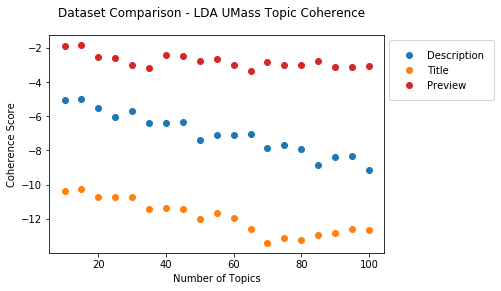

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


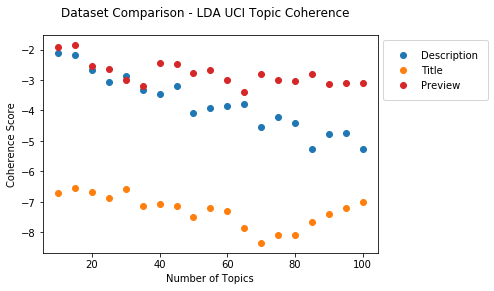

<Figure size 1000x600 with 0 Axes>

3
UMass title variance 1.065
UCI title variance 0.278
UMass description variance 1.549
UCI description variance 0.901
UMass preview variance 0.167
UCI preview variance 0.128
      Title        Description        Preview       
      UMass    UCI       UMass    UCI   UMass    UCI
10  -10.364 -6.718      -5.029 -2.108  -1.904 -1.757
15  -10.228 -6.538      -4.982 -2.166  -1.858 -2.123
20  -10.709 -6.692      -5.500 -2.685  -2.547 -2.142
25  -10.740 -6.868      -6.044 -3.063  -2.625 -2.757
30  -10.708 -6.569      -5.728 -2.860  -2.997 -2.751
35  -11.444 -7.125      -6.394 -3.325  -3.200 -3.149
40  -11.344 -7.071      -6.402 -3.462  -2.439 -2.594
45  -11.450 -7.126      -6.353 -3.189  -2.460 -2.254
50  -11.988 -7.488      -7.371 -4.098  -2.774 -2.194
55  -11.665 -7.217      -7.116 -3.905  -2.682 -2.447
60  -11.961 -7.291      -7.108 -3.846  -3.013 -2.497
65  -12.617 -7.851      -7.067 -3.781  -3.386 -2.461
70  -13.407 -8.348      -7.887 -4.547  -2.812 -2.066
75  -13.113 -8.078      -7.675 

In [406]:

visualize_coherence(
    'results_figures/lda/lda-umass-dataset-comparison.png',
    [lda_description_tc[0], lda_title_tc[0], lda_preview_tc[0]],
    'Dataset Comparison - LDA UMass Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda/lda-uci-dataset-comparison.png',
    [lda_description_tc[1], lda_title_tc[1], lda_preview_tc[0]],
    'Dataset Comparison - LDA UCI Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

desc_df = generate_tc_df(
    [ lda_title_tc[0], lda_description_tc[0], lda_preview_tc[0]],
    [ lda_title_tc[1], lda_description_tc[1], lda_preview_tc[1]],
    ['Title', 'Description', 'Preview'])


print('UMass title variance', calc_variance(lda_title_tc[0]))
print('UCI title variance', calc_variance(lda_title_tc[1]))
print('UMass description variance', calc_variance(lda_description_tc[0]))
print('UCI description variance', calc_variance(lda_description_tc[1]))
print('UMass preview variance', calc_variance(lda_preview_tc[0]))
print('UCI preview variance', calc_variance(lda_preview_tc[1]))

desc_df = desc_df.round(3)
print(desc_df)
print(desc_df.to_latex(index=True))


### lda2vec

INFO: creating evalution visualization


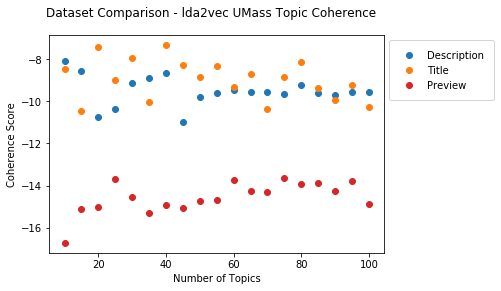

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


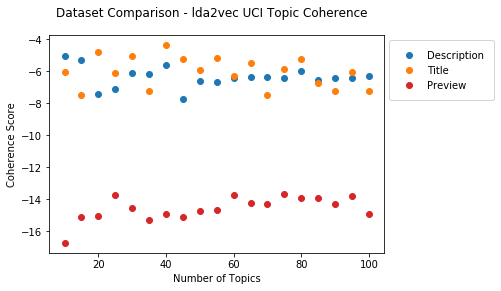

<Figure size 1000x600 with 0 Axes>

3
UMass title variance 0.903
UCI title variance 0.936
UMass description variance 0.493
UCI description variance 0.409
UMass preview variance 0.588
UCI preview variance 0.514
      Title        Description        Preview        
      UMass    UCI       UMass    UCI   UMass     UCI
10   -8.467 -6.003      -8.102 -5.023 -16.717 -13.474
15  -10.435 -7.471      -8.545 -5.307 -15.109 -13.119
20   -7.414 -4.765     -10.735 -7.396 -15.036 -12.749
25   -8.998 -6.074     -10.371 -7.084 -13.695 -12.317
30   -7.937 -5.026      -9.153 -6.115 -14.548 -12.174
35  -10.015 -7.245      -8.889 -6.156 -15.275 -12.683
40   -7.339 -4.362      -8.641 -5.582 -14.925 -12.061
45   -8.253 -5.227     -10.986 -7.708 -15.067 -12.288
50   -8.824 -5.880      -9.806 -6.577 -14.713 -12.002
55   -8.331 -5.158      -9.597 -6.652 -14.663 -12.104
60   -9.308 -6.268      -9.469 -6.379 -13.743 -11.530
65   -8.696 -5.493      -9.580 -6.328 -14.251 -11.848
70  -10.347 -7.495      -9.548 -6.319 -14.280 -11.514
75   -8.864 -5.8

In [407]:

visualize_coherence(
    'results_figures/lda2vec/lda2vec-umass-dataset-comparison.png',
    [lda2vec_description_tc[0], lda2vec_title_tc[0], lda2vec_preview_tc[0]],
    'Dataset Comparison - lda2vec UMass Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/lda2vec/lda2vec-uci-dataset-comparison.png',
    [lda2vec_description_tc[1], lda2vec_title_tc[1], lda2vec_preview_tc[0]],
    'Dataset Comparison - lda2vec UCI Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

desc_df = generate_tc_df(
    [ lda2vec_title_tc[0], lda2vec_description_tc[0], lda2vec_preview_tc[0]],
    [ lda2vec_title_tc[1], lda2vec_description_tc[1], lda2vec_preview_tc[1]],
    ['Title', 'Description',  'Preview'])


print('UMass title variance', calc_variance(lda2vec_title_tc[0]))
print('UCI title variance', calc_variance(lda2vec_title_tc[1]))
print('UMass description variance', calc_variance(lda2vec_description_tc[0]))
print('UCI description variance', calc_variance(lda2vec_description_tc[1]))
print('UMass preview variance', calc_variance(lsi_preview_tc[0]))
print('UCI preview variance', calc_variance(lsi_preview_tc[1]))

desc_df = desc_df.round(3)
print(desc_df)
print(desc_df.to_latex(index=True))


### ETM

INFO: creating evalution visualization


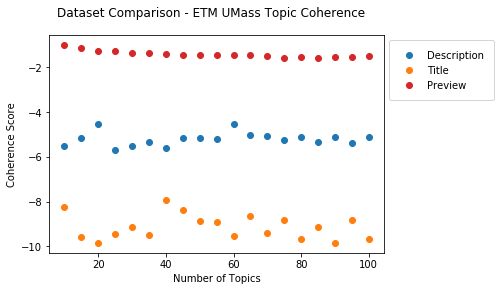

<Figure size 1000x600 with 0 Axes>

INFO: creating evalution visualization


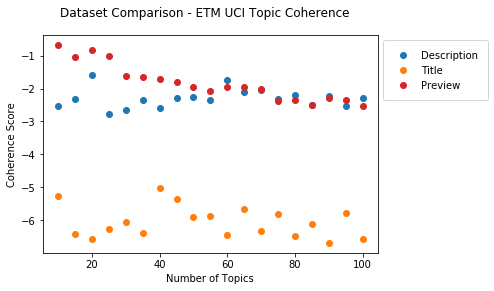

<Figure size 1000x600 with 0 Axes>

3
UMass title variance 0.311
UCI title variance 0.236
UMass description variance 0.094
UCI description variance 0.086
UMass preview variance 0.021
UCI preview variance 0.32
     Title        Description        Preview       
     UMass    UCI       UMass    UCI   UMass    UCI
10  -8.265 -5.273      -5.536 -2.517  -1.025 -0.683
15  -9.573 -6.428      -5.176 -2.330  -1.170 -1.047
20  -9.846 -6.576      -4.523 -1.583  -1.290 -0.839
25  -9.464 -6.280      -5.693 -2.775  -1.284 -1.009
30  -9.132 -6.043      -5.538 -2.654  -1.374 -1.617
35  -9.474 -6.392      -5.352 -2.333  -1.385 -1.648
40  -7.934 -5.010      -5.591 -2.603  -1.418 -1.702
45  -8.366 -5.353      -5.183 -2.271  -1.447 -1.812
50  -8.853 -5.888      -5.183 -2.259  -1.448 -1.961
55  -8.901 -5.886      -5.209 -2.361  -1.474 -2.083
60  -9.555 -6.461      -4.529 -1.724  -1.470 -1.938
65  -8.659 -5.651      -5.019 -2.093  -1.471 -1.948
70  -9.415 -6.341      -5.053 -2.057  -1.518 -2.013
75  -8.808 -5.822      -5.268 -2.308  -1.587 -2

In [408]:

visualize_coherence(
    'results_figures/etm/etm-umass-dataset-comparison.png',
    [etm_description_tc[0], etm_title_tc[0], etm_preview_tc[0]],
    'Dataset Comparison - ETM UMass Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

visualize_coherence(
    'results_figures/etm/etm-uci-dataset-comparison.png',
    [etm_description_tc[1], etm_title_tc[1], etm_preview_tc[1]],
    'Dataset Comparison - ETM UCI Topic Coherence',
    ['Description', 'Title', 'Preview'],
    ['tab:blue', 'tab:orange', 'tab:red'],
    10,
    105,
    5
)

desc_df = generate_tc_df(
    [ etm_title_tc[0], etm_description_tc[0], etm_preview_tc[0]],
    [ etm_title_tc[1], etm_description_tc[1], etm_preview_tc[1]],
    ['Title', 'Description',  'Preview'])


print('UMass title variance', calc_variance(etm_title_tc[0]))
print('UCI title variance', calc_variance(etm_title_tc[1]))
print('UMass description variance', calc_variance(etm_description_tc[0]))
print('UCI description variance', calc_variance(etm_description_tc[1]))
print('UMass preview variance', calc_variance(etm_preview_tc[0]))
print('UCI preview variance', calc_variance(etm_preview_tc[1]))


desc_df = desc_df.round(3)
print(desc_df)
print(desc_df.to_latex(index=True))
